### Introduction/Summary

#### Problem Statement

What factors determine a high-rating for a movie? This analysis investigated the features of what makes a good movie (high rating). Since the access rights to movies do cost companies like Netflix, it is important that they select movies that their users want to watch, otherwise, they might shift to competitors. The intent is to scrape movies from IMDB and look at the characteristics of a movie before it gets released. Is it possible to predict whether the movie will be a hit or not, and if it is possible, could a company leverage that information into buying low, that is buying its rights before it comes out?

Sections in this notebook are:

1) Collecting Data

2) Tidying Data

3) Setting features and target

4) Visualization

5) Modeling

#### Note: The code to scrape IMDB top10000 was from Amer Shalan, located [here](https://github.com/ashalan/GA-DSI/tree/master/projects/projects-weekly/project-06)

#### Importing Libraries

In [477]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler,StandardScaler,Normalizer,MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score
import json
import urllib
import requests
import json
import re
import csv
from bs4 import BeautifulSoup
import urllib
import pickle
import time
%matplotlib inline

### Collecting Data

In [2]:
r = urllib.urlopen('http://www.imdb.com/search/title?sort=num_votes,desc&title_type=feature&page='+str(1)).read()
soup = BeautifulSoup(r, 'lxml')
print soup.prettify()


<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="app-id=342792525, app-argument=imdb:///?src=mdot" name="apple-itunes-app"/>
  <script type="text/javascript">
   var ue_t0=window.ue_t0||+new Date();
  </script>
  <script type="text/javascript">
   var ue_mid = "A1EVAM02EL8SFB"; 
                var ue_sn = "www.imdb.com";  
                var ue_furl = "fls-na.amazon.com";
                var ue_sid = "000-0000000-0000000";
                var ue_id = "1TC25YKE7AVGNVXTG3CR";
                (function(e){var c=e;var a=c.ue||{};a.main_scope="mainscopecsm";a.q=[];a.t0=c.ue_t0||+new Date();a.d=g;function g(h){return +new Date()-(h?0:a.t0)}function d(h){return function(){a.q.push({n:h,a:arguments,t:a.d()})}}function b(m,l,h,j,i){var k={m:m,f:l,l:h,c:""+j,err:i,fromOnError:1,args:arguments};c.ueLogError(k);return false}b.skipTrace=1;e.on

In [4]:
def get_list(nums=range(1,201)):
    out = []
    skip = []
    for i in nums:
        try:
            # Open the page with Beautiful Soup
            r = urllib.urlopen('http://www.imdb.com/search/title?sort=num_votes,desc&title_type=feature&page='+str(i)).read()
            soup = BeautifulSoup(r, 'lxml')
            # Find all movie divs
            movs = soup.find_all("div", class_="lister-item-content")
            all_movies = []
            # print the page number that we are about parse
            print i
            for element in movs:
                # Get the individual elements in each movie
                title = element.a.get_text()
                year = int(element.find(class_="lister-item-year").get_text()[-5:-1])
                rating = float(element.find(class_="ratings-imdb-rating").strong.get_text())
                votes_gross = element.find_all("span", {"name":"nv"})
                votes = int(votes_gross[0].get_text().replace(',', ''))
                runtime = element.find(class_="runtime").get_text()
                genre = element.find("span",{"class":"genre"}).get_text()
                link =  element.a['href']
                elem_text =  element.text
                
                # Some movies did not have gross data
                try:
                    gross = round(eval(votes_gross[1].get_text().replace('$', '').replace('M', '*1000000')))
                except:
                    gross = np.nan
                # Some movies did not have a metascore
                try:
                    metascore = element.find(class_="ratings-metascore").span.get_text()
                except:
                    metascore = np.nan
                
                # 
                movie = {'title':title, 'year':year, 'rating':rating, 'votes':votes, 'gross':gross,\
                         'metascore':metascore, 'runtime':runtime,'genre':genre,'link': link,'text':elem_text}
                all_movies.append(movie)
            out = out + all_movies
        except:
            # Rather than rerunning the entire function if any page fails,
            # I am going to retrieve the skipped pages and add them to the skip list
            skip.append(i)
    print skip
    return out


In [7]:
top_10000 = get_list()
len(top_10000)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
[146, 200]


9900

In [25]:
skipped_pages = [146,200]
skipped = get_list(nums=[146,200])

146
200
[146, 200]


In [26]:
#pickling the data
with open('top_10000.pkl', 'w') as picklefile:
    pickle.dump(top_10000, picklefile)
    
with open('skipped_pages.pkl', 'w') as picklefile:
    pickle.dump(skipped, picklefile)    

### Data Munging

In [5]:
with open('top_10000.pkl', 'r') as picklefile:
    top_10000 = pickle.load(picklefile)
data = pd.DataFrame(top_10000)
data['text1'] = data['text'].apply(lambda x: x.strip(' ')).apply(lambda x: x.split('Director'))
director = []
for x in data['text1']:
    if len(x) ==2:
        director.append(x[1].replace('\n','').split('|')[0].replace(':',''))
    elif len(x)==3:
        director.append(x[2].replace('\n','').split('|')[0].replace(':',''))
    else:
        director.append(np.nan)
#     print len(x)
#    print x
#data['director'] = data['text1'].apply(lambda x: x[1].replace('\n','').split('|')[0].replace(':','') if len(x)==2 else x[2].replace('\n','').split('|')[0].replace(':',''))
print len(director)
print data.shape
data['director'] = director
actors = []
for x in data['text']:
    if len(x.split('Stars:')) == 2:
        actors.append(x.split('Stars:')[1].split('Votes')[0])
    else:
        actors.append(np.nan)
data['actors'] = actors
data['actors'] = data['actors'].apply(lambda x: x.replace('\n','').replace(' ','').split(',') if x is not np.nan else x)
data['link'] = data['link'].apply(lambda x: x.replace('/?ref_=adv_li_tt','')).apply(lambda x: "http://www.imdb.com"+x)
data_2000 = data[data['year']>=2000]
data_2000.shape

9900
(9900, 11)


(5677, 13)

In [6]:
data_2000['genre'] = data_2000['genre'].apply(lambda x: str(x).replace("\n",""))
data_2000['runtime'] = data_2000['runtime'].apply(lambda x: str(x).replace(" min","")).astype(int)
data_2000['gross'] = data_2000['gross'].apply(lambda x: x if x > 0 else 0).astype(int)
data_2000['year'] = pd.to_datetime(data_2000['year'],format='%Y').dt.year

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [751]:
# data_2000['director'] = data_2000['director'].apply(lambda x: x[1:] if len(x.split(','))>1 else x)

In [8]:
data_2000.sort_values('rating',ascending=False)

,genre,gross,link,metascore,rating,runtime,text,title,votes,year,text1,director,actors
5516,"Crime, Mystery, Thriller",0,http://www.imdb.com/title/tt5354160,NaN,9.7,144,"\n\n5,517.\nAynabaji\n(2016)\n\n\n144 min\n|\n...",Aynabaji,13986,2016,"[\n\n5,517.\nAynabaji\n(2016)\n\n\n144 min\n|\...",Amitabh Reza Chowdhury,"[ChanchalChowdhury, MasumaRahmanNabila, Bijori..."
1,"Action, Crime, Drama",533320000,http://www.imdb.com/title/tt0468569,82,9.0,152,\n\n2.\nThe Dark Knight\n(2008)\n\n\nPG-13\n|\...,The Dark Knight,1716168,2008,[\n\n2.\nThe Dark Knight\n(2008)\n\n\nPG-13\n|...,Christopher Nolan,"[ChristianBale, HeathLedger, AaronEckhart, Mic..."
8,"Adventure, Drama, Fantasy",377020000,http://www.imdb.com/title/tt0167260,94,8.9,201,\n\n9.\nThe Lord of the Rings: The Return of t...,The Lord of the Rings: The Return of the King,1243521,2003,[\n\n9.\nThe Lord of the Rings: The Return of ...,Peter Jackson,"[ElijahWood, ViggoMortensen, IanMcKellen, Orla..."
6398,"Crime, Drama, Thriller",0,http://www.imdb.com/title/tt3417422,NaN,8.9,160,"\n\n6,399.\nDrishyam\n(2013)\n\n\nNot Rated\n|...",Drishyam,10614,2013,"[\n\n6,399.\nDrishyam\n(2013)\n\n\nNot Rated\n...",Jeethu Joseph,"[Mohanlal, Meena, Ansiba, Esther]"
6885,"Adventure, Music, Mystery",0,http://www.imdb.com/title/tt4432480,NaN,8.9,149,"\n\n6,886.\nRangiTaranga\n(2015)\n\n\nNot Rate...",RangiTaranga,9304,2015,"[\n\n6,886.\nRangiTaranga\n(2015)\n\n\nNot Rat...",Anup Bhandari,"[NirupBhandari, RadhikaChetan, AvantikaShetty,..."
7790,"Adventure, Comedy, Drama",0,http://www.imdb.com/title/tt0367495,NaN,8.9,160,"\n\n7,841.\nAnbe Sivam\n(2003)\n\n\nNot Rated\...",Anbe Sivam,7155,2003,"[\n\n7,841.\nAnbe Sivam\n(2003)\n\n\nNot Rated...",Sundar C.,"[KamalHaasan, Madhavan, KiranRathod, Nassar]"
7806,"Animation, Drama, Romance",0,http://www.imdb.com/title/tt5311514,81,8.9,106,"\n\n7,857.\nKimi no na wa.\n(2016)\n\n\n106 mi...",Kimi no na wa.,7136,2016,"[\n\n7,857.\nKimi no na wa.\n(2016)\n\n\n106 m...",Makoto Shinkai,"[RyûnosukeKamiki, MoneKamishiraishi, RyôNarita..."
2,"Action, Adventure, Sci-Fi",292570000,http://www.imdb.com/title/tt1375666,74,8.8,148,\n\n3.\nInception\n(2010)\n\n\nPG-13\n|\n148 m...,Inception,1506934,2010,[\n\n3.\nInception\n(2010)\n\n\nPG-13\n|\n148 ...,Christopher Nolan,"[LeonardoDiCaprio, JosephGordon-Levitt, EllenP..."
6,"Adventure, Drama, Fantasy",313840000,http://www.imdb.com/title/tt0120737,92,8.8,178,\n\n7.\nThe Lord of the Rings: The Fellowship ...,The Lord of the Rings: The Fellowship of the Ring,1265999,2001,[\n\n7.\nThe Lord of the Rings: The Fellowship...,Peter Jackson,"[ElijahWood, IanMcKellen, OrlandoBloom, SeanBean]"
3124,Drama,0,http://www.imdb.com/title/tt0476735,NaN,8.7,108,"\n\n3,125.\nBabam ve Oglum\n(2005)\n\n\n108 mi...",Babam ve Oglum,36669,2005,"[\n\n3,125.\nBabam ve Oglum\n(2005)\n\n\n108 m...",Çagan Irmak,"[FikretKuskan, ÇetinTekindor, Hümeyra, SerifSe..."


### Visualizing the Data

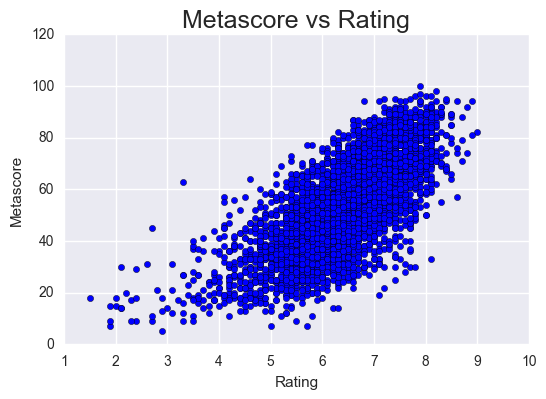

In [9]:
#meta score vs rating
plt.scatter(x=data_2000['rating'],y=data_2000['metascore'])
plt.title("Metascore vs Rating",fontsize=18)
plt.xlabel("Rating")
plt.ylabel("Metascore");

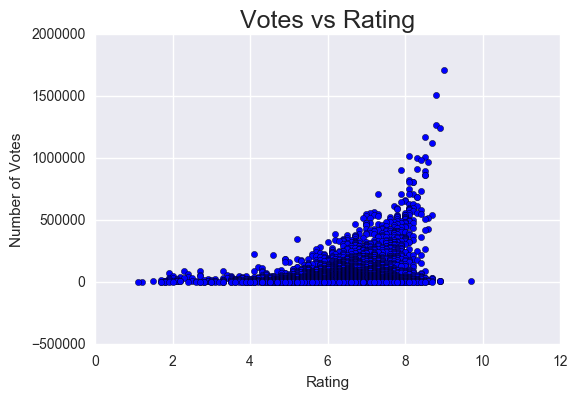

In [10]:
#number of votes are skewed
plt.scatter(x=data_2000['rating'],y=data_2000['votes'])
plt.title("Votes vs Rating",fontsize=18)
plt.xlabel("Rating")
plt.ylabel("Number of Votes");

### Feature Engineering
#### Directors
separating the directors list

In [11]:
#data_2000['director'] = data_2000['director'].apply(lambda x: x.replace('s','') if x[0]=='s' else x)
#manually update the only film without a director
no_dir_index = data_2000[data_2000['director'].isnull()].index.get_values()
data_2000.ix[no_dir_index,"director"]= "Don Hertzfeldt"

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
first_director = []
second_director = []
for x in data_2000['director']:
    if len(x.split(','))==1:
        first_director.append(x.split(',')[0])
        second_director.append(0)
    else:
        first_director.append(x.split(',')[0])
        second_director.append(x.split(',')[1])
data_2000['first_director'] = first_director
data_2000['second_director'] = second_director
data_2000

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,genre,gross,link,metascore,rating,runtime,text,title,votes,year,text1,director,actors,first_director,second_director
1,"Action, Crime, Drama",533320000,http://www.imdb.com/title/tt0468569,82,9.0,152,\n\n2.\nThe Dark Knight\n(2008)\n\n\nPG-13\n|\...,The Dark Knight,1716168,2008,[\n\n2.\nThe Dark Knight\n(2008)\n\n\nPG-13\n|...,Christopher Nolan,"[ChristianBale, HeathLedger, AaronEckhart, Mic...",Christopher Nolan,0
2,"Action, Adventure, Sci-Fi",292570000,http://www.imdb.com/title/tt1375666,74,8.8,148,\n\n3.\nInception\n(2010)\n\n\nPG-13\n|\n148 m...,Inception,1506934,2010,[\n\n3.\nInception\n(2010)\n\n\nPG-13\n|\n148 ...,Christopher Nolan,"[LeonardoDiCaprio, JosephGordon-Levitt, EllenP...",Christopher Nolan,0
6,"Adventure, Drama, Fantasy",313840000,http://www.imdb.com/title/tt0120737,92,8.8,178,\n\n7.\nThe Lord of the Rings: The Fellowship ...,The Lord of the Rings: The Fellowship of the Ring,1265999,2001,[\n\n7.\nThe Lord of the Rings: The Fellowship...,Peter Jackson,"[ElijahWood, IanMcKellen, OrlandoBloom, SeanBean]",Peter Jackson,0
8,"Adventure, Drama, Fantasy",377020000,http://www.imdb.com/title/tt0167260,94,8.9,201,\n\n9.\nThe Lord of the Rings: The Return of t...,The Lord of the Rings: The Return of the King,1243521,2003,[\n\n9.\nThe Lord of the Rings: The Return of ...,Peter Jackson,"[ElijahWood, ViggoMortensen, IanMcKellen, Orla...",Peter Jackson,0
10,"Action, Thriller",448130000,http://www.imdb.com/title/tt1345836,78,8.5,164,\n\n11.\nThe Dark Knight Rises\n(2012)\n\n\nPG...,The Dark Knight Rises,1171885,2012,[\n\n11.\nThe Dark Knight Rises\n(2012)\n\n\nP...,Christopher Nolan,"[ChristianBale, TomHardy, AnneHathaway, GaryOl...",Christopher Nolan,0
11,"Adventure, Drama, Fantasy",340480000,http://www.imdb.com/title/tt0167261,88,8.7,179,\n\n12.\nThe Lord of the Rings: The Two Towers...,The Lord of the Rings: The Two Towers,1126345,2002,[\n\n12.\nThe Lord of the Rings: The Two Tower...,Peter Jackson,"[ElijahWood, IanMcKellen, ViggoMortensen, Orla...",Peter Jackson,0
13,"Action, Sci-Fi",623280000,http://www.imdb.com/title/tt0848228,69,8.1,143,\n\n14.\nThe Avengers\n(2012)\n\n\nPG-13\n|\n1...,The Avengers,1017292,2012,[\n\n14.\nThe Avengers\n(2012)\n\n\nPG-13\n|\n...,Joss Whedon,"[RobertDowneyJr., ChrisEvans, ScarlettJohansso...",Joss Whedon,0
14,"Action, Adventure, Drama",187670000,http://www.imdb.com/title/tt0172495,64,8.5,155,\n\n15.\nGladiator\n(2000)\n\n\nR\n|\n155 min\...,Gladiator,1006832,2000,[\n\n15.\nGladiator\n(2000)\n\n\nR\n|\n155 min...,Ridley Scott,"[RussellCrowe, JoaquinPhoenix, ConnieNielsen, ...",Ridley Scott,0
15,"Action, Adventure",205340000,http://www.imdb.com/title/tt0372784,70,8.3,140,\n\n16.\nBatman Begins\n(2005)\n\n\nPG-13\n|\n...,Batman Begins,1004895,2005,[\n\n16.\nBatman Begins\n(2005)\n\n\nPG-13\n|\...,Christopher Nolan,"[ChristianBale, MichaelCaine, KenWatanabe, Lia...",Christopher Nolan,0
16,"Drama, Western",162800000,http://www.imdb.com/title/tt1853728,81,8.4,165,\n\n17.\nDjango Unchained\n(2012)\n\n\nR\n|\n1...,Django Unchained,983823,2012,[\n\n17.\nDjango Unchained\n(2012)\n\n\nR\n|\n...,Quentin Tarantino,"[JamieFoxx, ChristophWaltz, LeonardoDiCaprio, ...",Quentin Tarantino,0


In [13]:
num_directors = []
for x in data_2000['director']:
    num_directors.append(len(x.split(',')))
    if len(x.split(',')) > 1:
        print x.split(',')[0][1:],",",x.split(',')[1]
    else:
        pass

Quentin Tarantino ,  Eli Roth
Andrew Stanton ,  Lee Unkrich
Pete Docter ,  Bob Peterson
Frank Miller ,  Robert Rodriguez
Danny Boyle ,  Loveleen Tandan
Ethan Coen ,  Joel Coen
Pete Docter ,  David Silverman
Fernando Meirelles ,  Kátia Lund
Olivier Nakache ,  Eric Toledano
Anthony Russo ,  Joe Russo
Dean DeBlois ,  Chris Sanders
Brad Bird ,  Jan Pinkava
Andrew Adamson ,  Vicky Jenson
Chris Buck ,  Jennifer Lee
Lana Wachowski ,  Lilly Wachowski
Phil Lord ,  Christopher Miller
Pierre Coffin ,  Chris Renaud
Glenn Ficarra ,  John Requa
Pete Docter ,  Ronnie Del Carmen
Lana Wachowski ,  Lilly Wachowski
Eric Bress ,  J. Mackye Gruber
Jonathan Dayton ,  Valerie Faris
Anthony Russo ,  Joe Russo
Chris Wedge ,  Carlos Saldanha
Andrew Adamson ,  Kelly Asbury
Evan Goldberg ,  Seth Rogen
Mark Osborne ,  John Stevenson
Nathan Greno ,  Byron Howard
Pierre Coffin ,  Chris Renaud
Don Hall ,  Chris Williams
Tom Tykwer ,  Lana Wachowski
Mark Andrews ,  Brenda Chapman
Eric Darnell ,  Tom McGrath
John Lasse

In [14]:
num_directors = []
tot_directors = []
for x in data_2000['director']:
    num_directors.append(len(x.split(",")))
    for y in (x.split(",")):
        tot_directors.append(y.strip())
pd.Series(tot_directors).value_counts()

Steven Soderbergh       18
Woody Allen             17
Clint Eastwood          14
Tyler Perry             14
Ridley Scott            13
Richard Linklater       12
Steven Spielberg        12
Robert Rodriguez        12
Uwe Boll                11
Ron Howard              11
Shawn Levy              11
David Gordon Green      11
Lasse Hallström         11
Michael Winterbottom    11
Antoine Fuqua           10
François Ozon           10
Stephen Frears          10
Renny Harlin            10
Brett Ratner            10
Peter Farrelly          10
Chan-wook Park           9
Gus Van Sant             9
Paul Weitz               9
Michael Bay              9
sBobby Farrelly          9
Todd Phillips            9
Dennis Dugan             9
Takashi Miike            9
Tim Burton               9
Joel Schumacher          9
                        ..
Jérôme Enrico            1
Diane Keaton             1
Jean-Pierre Améris       1
Hyun-seung Lee           1
Silvio Soldini           1
Chris Hopewell           1
M

#### Actors List
separating the actors

In [15]:
#three movies have no actors list.
data_2000[data_2000['actors'].isnull()]


,genre,gross,link,metascore,rating,runtime,text,title,votes,year,text1,director,actors,first_director,second_director
2176,"Action, Adventure, Drama",6260000,http://www.imdb.com/title/tt2017038,87,6.9,106,"\n\n2,177.\nAll Is Lost\n(2013)\n\n\nPG-13\n|\...",All Is Lost,60787,2013,"[\n\n2,177.\nAll Is Lost\n(2013)\n\n\nPG-13\n|...",J.C. Chandor,NaN,J.C. Chandor,0
8184,"Animation, Comedy, Drama",0,http://www.imdb.com/title/tt2396224,90,8.3,62,"\n\n8,235.\nIt's Such a Beautiful Day\n(2012)\...",It's Such a Beautiful Day,6542,2012,"[\n\n8,235.\nIt's Such a Beautiful Day\n(2012)...",Don Hertzfeldt,NaN,Don Hertzfeldt,0
9561,"Animation, Adventure, Family",0,http://www.imdb.com/title/tt2368672,NaN,7.2,89,"\n\n9,612.\nMinuscule: Valley of the Lost Ants...",Minuscule: Valley of the Lost Ants,4957,2013,"[\n\n9,612.\nMinuscule: Valley of the Lost Ant...","sHélène Giraud, Thomas SzaboVotes4,957",NaN,sHélène Giraud,Thomas SzaboVotes4


In [16]:
data_2000[data_2000['actors'].isnull()].index.get_values()
#first one (All is Lost) stars Robert Redford
#last two are animation so they are none.
all_is_lost_index = data_2000[data_2000['title'] == "All Is Lost"].index.get_values()[0]
data_2000.ix[all_is_lost_index,'actors'] = ["RobertRedford"]

In [17]:
primary_actors = []
for x in data_2000[(data_2000['actors'].notnull()) & (data_2000['rating'] >= 8.0)]['actors']:
    primary_actors.append(x[0])

In [18]:
all_actors = []
for x in data_2000[(data_2000['actors'].notnull())  & (data_2000['rating'] >= 8.0)]['actors']:
    for y in x:
        all_actors.append(y)

In [19]:
actors = pd.Series(all_actors).value_counts()
actors_df = pd.DataFrame(actors,columns = ["Primary"] )
prime_actors =  pd.Series(primary_actors).value_counts()
# for actor in data_2000['actors']:
#     print str(actor).
prime_actors_df = pd.DataFrame(prime_actors,columns = ["Primary"] )

In [20]:
data_2000.shape

(5677, 15)

### Data Collection II
#### Scraping Budget, Production Companies from each Movie Listing

In [752]:
# #for x in data['link']:
# a = urllib.urlopen("http://www.imdb.com/title/tt0111161").read()
# soup = BeautifulSoup(a, 'lxml')
# print soup.prettify()


In [29]:
#grabbing budget, production companies, awards, rating of each movie
def get_budget(links):
    out = []
    skip = []
    all_listings = []
    num = 0
    for i in links:
        try:
            # Open the page with Beautiful Soup
            r = urllib.urlopen(str(i)).read()
            soup = BeautifulSoup(r, 'lxml')
            itemprop = []
            movie_itemprop = []
            # Find all movie divs
            #movs = soup.find_all("div", class_="lister-item-content")
            
            # print the page number that we are about parse
            print i
            rated = soup.find('span',itemprop="contentRating").text
            #print rated
            listing = {}
                # Some movies did not have gross data
            try:
                budget = [str(b.text).split('\n')[1] for b in soup.findAll('div',class_='txt-block') if "Budget" in str(b)]
                budget = str(budget).split(':')[-1].strip().replace(' ','')
                awards = [str(x).strip() for x in soup.find("span",itemprop="awards")]
                creators = [x.text for x in soup.find_all("span",itemprop="creator")]
                #print budget
            except:
                #budget = np.nan
                #print budget
                pass
                # 
            listing = {'link':i, 'rated':rated, 'Budget':budget,'num':num,'awards':awards, 'creators':creators}
            all_listings.append(listing)
            #print listing
            out = out + all_listings
        except:
            # Rather than rerunning the entire function if any page fails,
            # I am going to retrieve the skipped pages and add them to the skip list
            #skip.append(i)
            pass
        num+=1
        if num == 50:
            time.sleep(20)
    #print skip
    return all_listings

In [32]:
#calling the first 1000
listing_budget = get_budget(data_2000['link'][0:1000])
with open('listing_budget_1000.pkl', 'w') as picklefile:
    pickle.dump(listing_budget, picklefile)

http://www.imdb.com/title/tt0468569
http://www.imdb.com/title/tt1375666
http://www.imdb.com/title/tt0120737
http://www.imdb.com/title/tt0167260
http://www.imdb.com/title/tt1345836
http://www.imdb.com/title/tt0167261
http://www.imdb.com/title/tt0848228
http://www.imdb.com/title/tt0172495
http://www.imdb.com/title/tt0372784
http://www.imdb.com/title/tt1853728
http://www.imdb.com/title/tt0816692
http://www.imdb.com/title/tt0361748
http://www.imdb.com/title/tt0499549
http://www.imdb.com/title/tt0407887
http://www.imdb.com/title/tt0482571
http://www.imdb.com/title/tt0209144
http://www.imdb.com/title/tt0325980
http://www.imdb.com/title/tt0434409
http://www.imdb.com/title/tt0993846
http://www.imdb.com/title/tt1130884
http://www.imdb.com/title/tt0266697
http://www.imdb.com/title/tt0910970
http://www.imdb.com/title/tt0266543
http://www.imdb.com/title/tt1392170
http://www.imdb.com/title/tt0371746
http://www.imdb.com/title/tt2015381
http://www.imdb.com/title/tt1049413
http://www.imdb.com/title/tt

In [34]:
#calling 1000-3000 titles
listing_budget_2000 = get_budget(data_2000['link'][1000:2000])
with open('listing_budget_2000.pkl', 'w') as picklefile:
    pickle.dump(listing_budget_2000, picklefile)
time.sleep(60)
listing_budget_3000 = get_budget(data_2000['link'][2000:3000])
with open('listing_budget_3000.pkl', 'w') as picklefile:
    pickle.dump(listing_budget_3000, picklefile)

http://www.imdb.com/title/tt1924429
http://www.imdb.com/title/tt0758730
http://www.imdb.com/title/tt0430357
http://www.imdb.com/title/tt1517260
http://www.imdb.com/title/tt0482606
http://www.imdb.com/title/tt0810819
http://www.imdb.com/title/tt0338564
http://www.imdb.com/title/tt0404203
http://www.imdb.com/title/tt0790736
http://www.imdb.com/title/tt0385004
http://www.imdb.com/title/tt3464902
http://www.imdb.com/title/tt0907657
http://www.imdb.com/title/tt0445922
http://www.imdb.com/title/tt0245574
http://www.imdb.com/title/tt1486185
http://www.imdb.com/title/tt1821549
http://www.imdb.com/title/tt0462590
http://www.imdb.com/title/tt0337741
http://www.imdb.com/title/tt4776998
http://www.imdb.com/title/tt1904996
http://www.imdb.com/title/tt0465580
http://www.imdb.com/title/tt1131729
http://www.imdb.com/title/tt0200550
http://www.imdb.com/title/tt0190138
http://www.imdb.com/title/tt0780521
http://www.imdb.com/title/tt1634122
http://www.imdb.com/title/tt0401383
http://www.imdb.com/title/tt

In [43]:
#calling the remaining titles
time.sleep(60)
listing_budget_4000 = get_budget(data_2000['link'][3000:4000])
with open('listing_budget_4000.pkl', 'w') as picklefile:
    pickle.dump(listing_budget_4000, picklefile)
time.sleep(60)
listing_budget_5000 = get_budget(data_2000['link'][4000:])
with open('listing_budget_5000.pkl', 'w') as picklefile:
    pickle.dump(listing_budget_5000, picklefile)

http://www.imdb.com/title/tt0443559
http://www.imdb.com/title/tt2452254
http://www.imdb.com/title/tt1124037
http://www.imdb.com/title/tt0214388
http://www.imdb.com/title/tt0120753
http://www.imdb.com/title/tt2473794
http://www.imdb.com/title/tt0416185
http://www.imdb.com/title/tt0470883
http://www.imdb.com/title/tt0497137
http://www.imdb.com/title/tt0432402
http://www.imdb.com/title/tt0367085
http://www.imdb.com/title/tt1924394
http://www.imdb.com/title/tt1151922
http://www.imdb.com/title/tt0780607
http://www.imdb.com/title/tt0326905
http://www.imdb.com/title/tt0964587
http://www.imdb.com/title/tt0331468
http://www.imdb.com/title/tt0120202
http://www.imdb.com/title/tt0338216
http://www.imdb.com/title/tt0164212
http://www.imdb.com/title/tt0295427
http://www.imdb.com/title/tt1231586
http://www.imdb.com/title/tt0164961
http://www.imdb.com/title/tt1247690
http://www.imdb.com/title/tt1621039
http://www.imdb.com/title/tt0351817
http://www.imdb.com/title/tt0956038
http://www.imdb.com/title/tt

#### Data Munging, Feature Engineering

1) Setting up the DataFrame

2) Data Munging

3) Feature Engineering for Production Companies, screenplay/novel

In [407]:
budget_1000 = pd.DataFrame(listing_budget)
budget_2000 = pd.DataFrame(listing_budget_2000)
budget_3000 = pd.DataFrame(listing_budget_3000)
budget_4000 = pd.DataFrame(listing_budget_4000)
budget_5000 = pd.DataFrame(listing_budget_5000)
#budget_1000,
budget = pd.concat([budget_1000,budget_2000,budget_3000,budget_4000,budget_5000],axis=0)
budget['Budget'] = budget['Budget'].apply(lambda x: x.replace('$','').replace('\']',"").replace(',',''))
budget['Budget'] = budget['Budget'].apply(lambda x: str(x).replace('[]','0')).astype(int)
budget['rated'] = budget['rated'].apply(lambda x: x.replace(': ','').replace('- ',''))

budget['movie_rating'] = budget['rated'].apply(lambda x: (x.split())[1] if len(x.split()) > 3 else x )
budget['movie_rating'].value_counts()
budget[(budget['movie_rating']=="Rated") | (budget['movie_rating']=="for")]
budget['movie_rating'] = budget['movie_rating'].apply(lambda x: 'PG-13' if x=='for' else x)
del budget['rated']
print 'data_2000 shape is:',data_2000.shape

#-------------CODE FOR FINDING PRODUCTION COMPANIES---------------
creators = {}
for creator in budget['creators']:
    #x = str(x).replace('\n','')
    for x in creator:
        x=x.strip()
        if x not in creators:
            creators[x]=1
        else:
            creators[x]+=1
companies = []
number_films = []
for w in sorted(creators, key=creators.get, reverse=True):
    #print w, creators[w]
    companies.append(w)
    number_films.append(creators[w])
company_films = pd.concat([pd.Series(companies,name='Prod_comp'),pd.Series(number_films,name='Count')],axis=1)
company_films['Prod_comp'] = company_films['Prod_comp'].apply(lambda x: x[0:])

big_six = ['Universal Pictures','Warner Bros.','Paramount Pictures','Twentieth Century Fox Film Corporation',\
           'Columbia Pictures','Walt Disney Pictures','Columbia Pictures Corporation']


top_10_co = []
for x in company_films[:10]['Prod_comp']:
    top_10_co.append(x)
    
second_10_co = []
for x in company_films[10:20]['Prod_comp']:
    second_10_co.append(x)
third_10_co = []
for x in company_films[20:30]['Prod_comp']:
    third_10_co.append(x)
company_films.head()

budget['third_to_last'] = budget['creators'].apply(lambda x: x[-3][1:] if len(x) > 2 else x)
budget['second_to_last'] = budget['creators'].apply(lambda x: x[-2][1:] if len(x) > 2 else x)
budget['last'] = budget['creators'].apply(lambda x: x[-1][1:] if len(x) > 2 else x)
prod_co_1 = []
prod_co_2 = []
prod_co_3 = []
big_six_co = []

for x,y,z in zip(budget['third_to_last'],budget['second_to_last'],budget['last']):
    if (x in top_10_co) or (y in top_10_co) or (z in top_10_co):
        prod_co_1.append(1)
    else:
        prod_co_1.append(0)
for x,y,z in zip(budget['third_to_last'],budget['second_to_last'],budget['last']):
    if (x in second_10_co) or (y in second_10_co) or (z in second_10_co):
        prod_co_2.append(1)
    else:
        prod_co_2.append(0)

for x,y,z in zip(budget['third_to_last'],budget['second_to_last'],budget['last']):
    if (x in third_10_co) or (y in third_10_co) or (z in third_10_co):
        prod_co_3.append(1)
    else:
        prod_co_3.append(0)
for x,y,z in zip(budget['third_to_last'],budget['second_to_last'],budget['last']):
    if (x in big_six) or (y in big_six) or (z in big_six):
        big_six_co.append(1)
    else:
        big_six_co.append(0)
budget['big_six'] = big_six_co
#budget['Top_Prod_Co'] = prod_co_1        
#budget['Second_Prod_Co'] = prod_co_2       
#budget['Third_Prod_Co'] = prod_co_3


#-----------code for finding screenplay,novel bins
screenplay = []
novel = []
comic_story = []
other_type = []
for creators in budget['creators']:
    if ("screenplay" in str(creators)) and ("novel" in str(creators)):
        screenplay.append(1)
        novel.append(1)
        comic_story.append(0)
        other_type.append(0)
    elif ("screenplay" in str(creators)) and ("novel" not in str(creators)):
        screenplay.append(1)
        novel.append(0)
        comic_story.append(0)
        other_type.append(0)
    elif ("screenplay" not in str(creators)) and ("novel" in str(creators)):
        screenplay.append(0)
        novel.append(1)
        comic_story.append(0)
        other_type.append(0)
    elif ("story" in str(creators)) or ("comic" in str(creators)):
        screenplay.append(0)
        novel.append(0)
        comic_story.append(1)
        other_type.append(0)
    else:
        screenplay.append(0)
        novel.append(0)
        comic_story.append(0)
        other_type.append(1)
budget['screenplay'] = screenplay
budget['novel'] = novel
budget['comic_story'] = comic_story
budget['other_type'] = other_type
#awards
oscar_won = budget['awards'].apply(lambda x: 1 if ("Won" in str(x)) and ("Oscar" in str(x)) else 0)
oscar_nom = budget['awards'].apply(lambda x: 1 if (("Nominat" in str(x)) or ("Won" in str(x)) ) and ("Oscar" in str(x)) else 0)
budget['oscar_won'] = oscar_won
budget['oscar_nom'] = oscar_nom

del budget['third_to_last'],budget['second_to_last'],budget['last'],budget['num'],budget['creators'],budget['awards']
print 'budget df shape is:',budget.shape
#there are about 700 movies not scraped

data_2000 shape is: (5677, 15)
budget df shape is: (4982, 10)


#### Data Aggregation - Merging Dataframes

In [408]:
movies = pd.merge(data_2000,budget,on="link")
print movies.shape
print "missing values, where budget is null", movies[(movies['Budget'] == 0)].shape
movies_df = movies[(movies['Budget'] != 0)].sort_values('rating',ascending=False)
print 'no missing budget',movies[movies['Budget']!=0].shape
movies = movies[movies['Budget']!=0]
del movies['text1'], movies['text']
movies.columns

(4986, 24)
missing values (1413, 24)
no missing budget (3573, 24)


Index([u'genre', u'gross', u'link', u'metascore', u'rating', u'runtime',
       u'title', u'votes', u'year', u'director', u'actors', u'first_director',
       u'second_director', u'Budget', u'movie_rating', u'big_six',
       u'screenplay', u'novel', u'comic_story', u'other_type', u'oscar_won',
       u'oscar_nom'],
      dtype='object')

In [409]:
#finding the movie rating bins
movies['movie_rating'].value_counts()
rated_r = []
rated_pg13 = []
rated_pg = []
rated_g = []
rated_other = []

for rating in movies['movie_rating']:
    r=0
    pg13=0
    pg=0
    g=0
    other=0
    #print rating
    if rating=='R':
        r=1
    elif rating=='PG-13':
        pg13=1
    elif rating=='PG':
        pg=1
    elif rating=='G':
        g=1
    else:
        other=1
    rated_r.append(r)
    rated_pg13.append(pg13)
    rated_pg.append(pg)
    rated_g.append(g)
    rated_other.append(other)

movies['rated_r'] = rated_r
movies['rated_pg13'] = rated_pg13
movies['rated_pg'] = rated_pg
movies['rated_g'] = rated_g
movies.shape
#calling datetime
movies['year'] = pd.to_datetime(movies['year'],format="%Y").dt.year

(3573, 26)

In [801]:
movies.corr()
#oscar won, nomination, and runtime 
# def correlation_matrix(df):
#     from matplotlib import cm as cm
#     fig = plt.figure()
#     ax1 = fig.add_subplot(111)
#     cmap = cm.get_cmap('jet', 30)
#     cax = ax1.imshow(movies.corr(), interpolation="nearest", cmap=cmap)
#     ax1.grid(True)
#     plt.title('Abalone Feature Correlation')
#     labels=[movies.columns]
#     ax1.set_xticklabels(labels,fontsize=6)
#     ax1.set_yticklabels(labels,fontsize=6)
#     # Add colorbar, make sure to specify tick locations to match desired ticklabels
#     cbar = fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
#     plt.show()

# correlation_matrix(movies)

,gross,rating,runtime,votes,year,Budget,big_six,screenplay,novel,comic_story,other_type,oscar_won,oscar_nom,rated_r,rated_pg13,rated_pg,rated_g
gross,1.000000,0.198422,0.268113,0.680685,0.054286,0.705871,0.367004,0.097414,-0.010139,0.085432,-0.122481,0.240383,0.300777,-0.290374,0.211694,0.190366,0.092809
rating,0.198422,1.000000,0.432019,0.437592,0.039970,0.110881,0.028271,0.093327,0.066395,-0.032045,-0.078494,0.261603,0.374772,0.077450,-0.076895,-0.054117,0.009032
runtime,0.268113,0.432019,1.000000,0.384319,0.041973,0.323590,0.137005,0.128233,0.098149,-0.037909,-0.108029,0.220095,0.296387,-0.010582,0.108252,-0.131887,-0.102648
votes,0.680685,0.437592,0.384319,1.000000,0.021135,0.509431,0.279735,0.103721,0.025066,0.033497,-0.107921,0.389765,0.429046,-0.066750,0.137231,-0.031280,0.014500
year,0.054286,0.039970,0.041973,0.021135,1.000000,0.052408,-0.064210,0.089496,-0.041360,-0.093350,-0.040226,-0.017531,-0.032626,-0.007116,-0.020998,0.022427,-0.049186
Budget,0.705871,0.110881,0.323590,0.509431,0.052408,1.000000,0.445086,0.144907,-0.013054,0.087331,-0.170147,0.127123,0.217804,-0.333380,0.234789,0.215434,0.088072
big_six,0.367004,0.028271,0.137005,0.279735,-0.064210,0.445086,1.000000,0.071291,0.008156,0.089569,-0.104709,0.071306,0.106864,-0.202309,0.137491,0.143639,0.069601
screenplay,0.097414,0.093327,0.128233,0.103721,0.089496,0.144907,0.071291,1.000000,0.267212,-0.209550,-0.856400,0.038218,0.085235,-0.083999,0.042534,0.088450,0.003389
novel,-0.010139,0.066395,0.098149,0.025066,-0.041360,-0.013054,0.008156,0.267212,1.000000,-0.082319,-0.336425,0.029695,0.053529,0.031284,-0.018915,-0.008103,-0.019125
comic_story,0.085432,-0.032045,-0.037909,0.033497,-0.093350,0.087331,0.089569,-0.209550,-0.082319,1.000000,-0.252620,0.005017,-0.003506,-0.076034,0.026673,0.023588,0.141849


### Visualizations


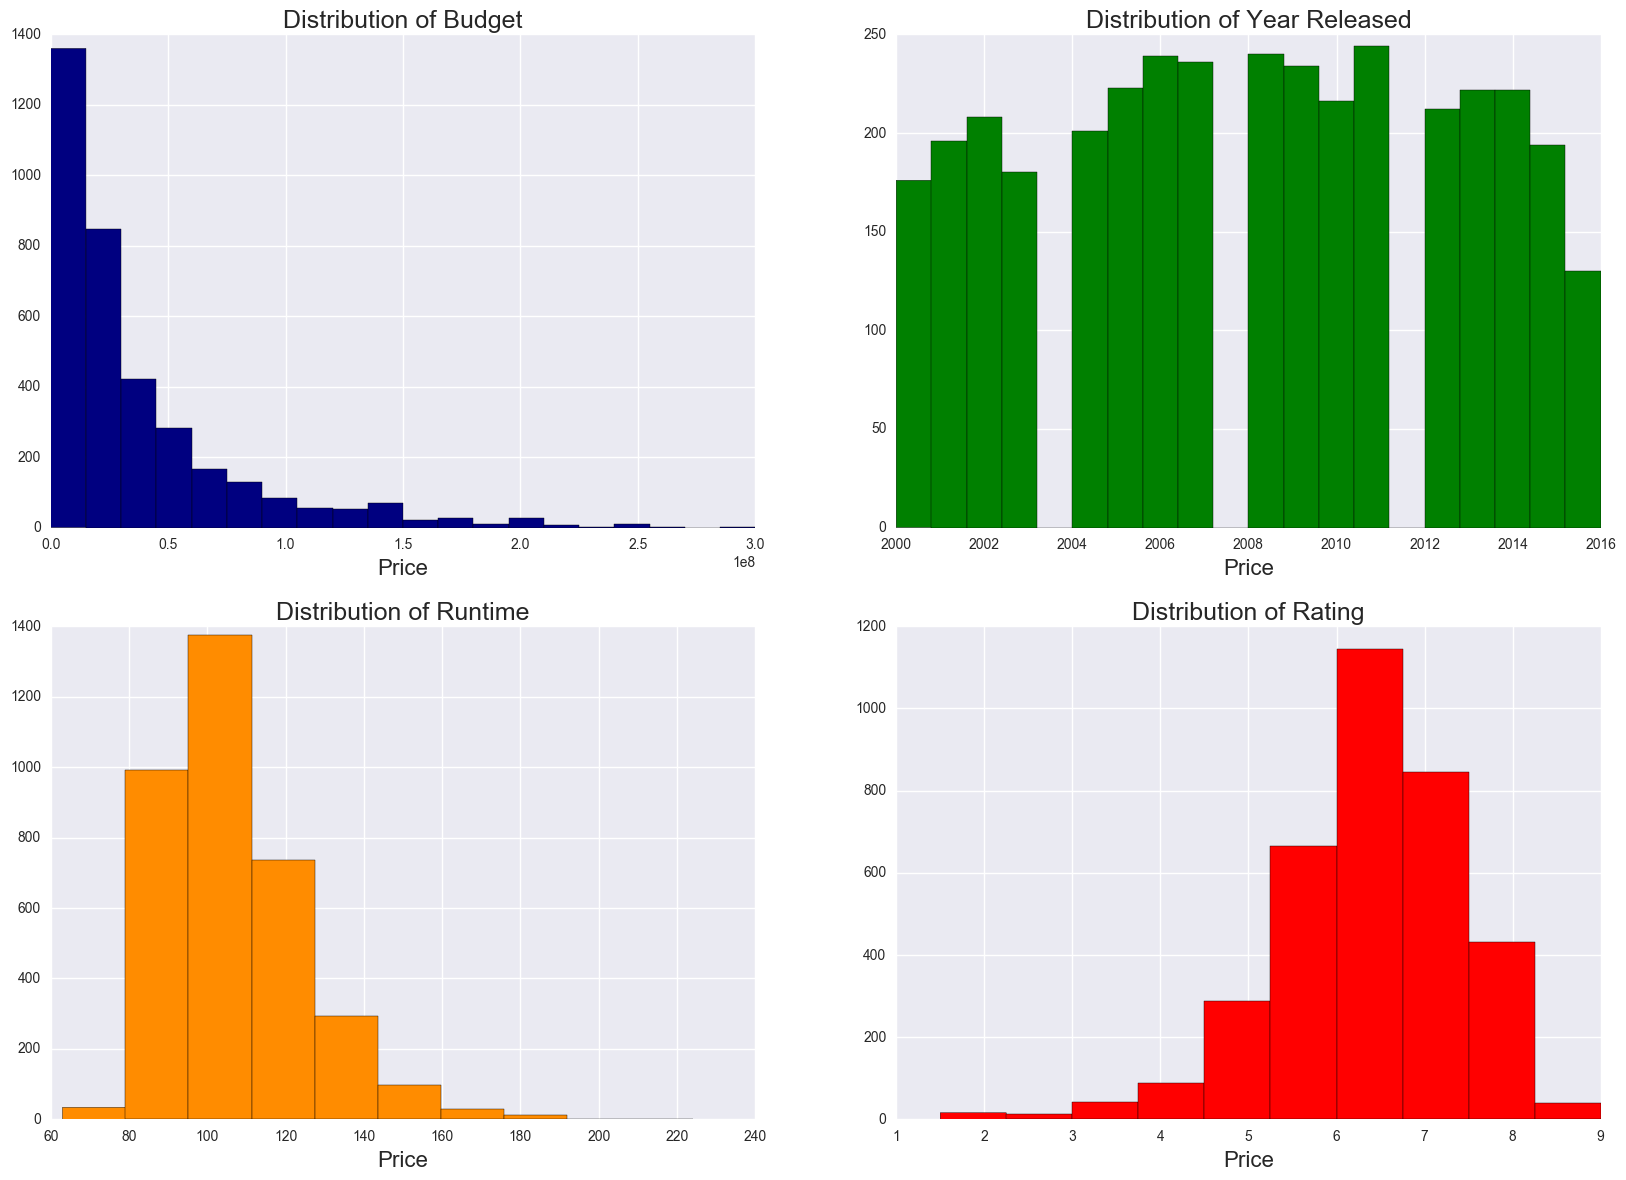

In [784]:
#histograms of Budget, Year Released, Runtime, and Rating
fig,axes = plt.subplots(2,2,figsize=(20,14))
axes[0][0].hist(x = movies['Budget'],bins=20,color='navy')
axes[0][0].set_title("Distribution of Budget",fontsize = 18)
axes[0][0].set_xlabel("Price",fontsize = 16)

axes[0][1].hist(x=movies['year'],bins=20,color='green')
axes[0][1].set_title('Distribution of Year Released',fontsize=18)
axes[0][1].set_xlabel('Price',fontsize=16)

axes[1][0].hist(x=movies['runtime'],color='darkorange')
axes[1][0].set_title('Distribution of Runtime',fontsize=18)
axes[1][0].set_xlabel('Price',fontsize=16)

axes[1][1].hist(x=movies['rating'],color='red')
axes[1][1].set_title('Distribution of Rating',fontsize=18)
axes[1][1].set_xlabel('Price',fontsize=16)
plt.show();

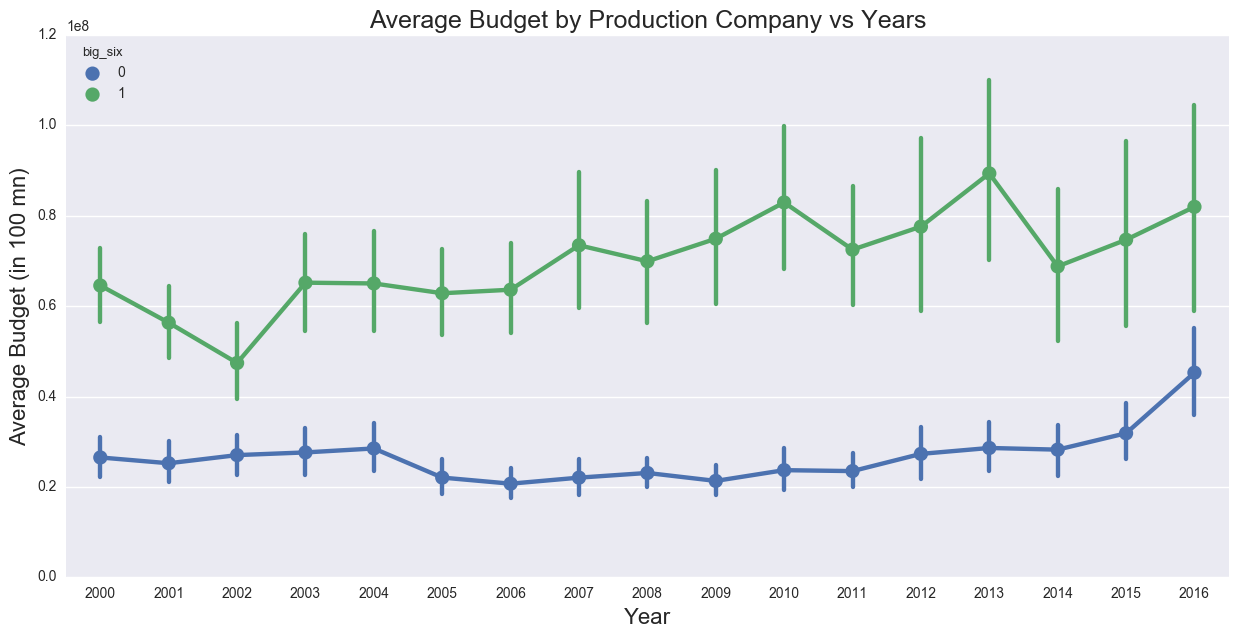

In [809]:
#plotting budget vs year, shows a slight upward trend, and shows disparity between big six and other production companies
#shows a higher range for big six vs non big-six prod companies
plt.subplots(figsize=(15,7))
sns.pointplot(data=movies,x='year',y='Budget',hue='big_six')
plt.title('Average Budget by Production Company vs Years',fontsize=18)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Average Budget (in 100 mn)',fontsize=16);

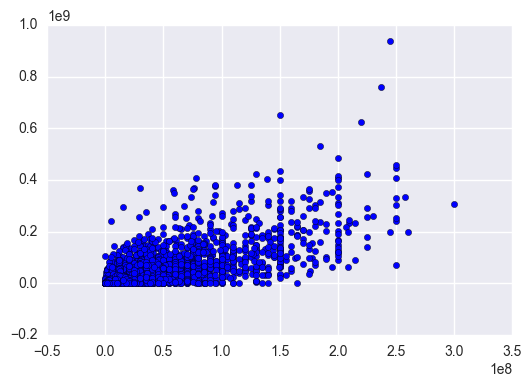

In [792]:
plt.scatter(x=movies['Budget'],y=movies['gross'])


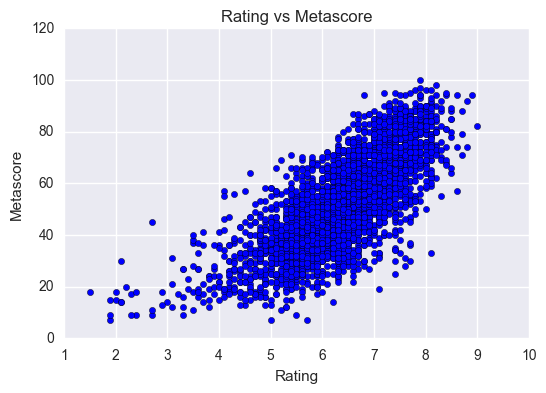

In [790]:
#shows a positive correlation
plt.scatter(x=movies['rating'],y=movies['metascore'])
plt.title('Rating vs Metascore')
plt.xlabel('Rating')
plt.ylabel('Metascore');

#### Feature Engineering - Directors & Actors, Setting up data for Modeling

1) Binning/Categorizing Directors

2) Binning/Categorizing Actors

3) Setting up X's and y's for model testing

In [758]:
#featuring engineering -directors
topdirector_list = []
for x in movies[movies['rating'] >= 8.0]['director']:
    for y in x.split(','):
        topdirector_list.append(y.strip())
topdirector_df = pd.Series(topdirector_list).value_counts().to_frame('count_top')
topdirector_df['rank'] = topdirector_df["count_top"].apply(lambda x: 'super' if x > 1 else "top")
topdirector_df.reset_index(inplace = True)

alldirector_list = []
director_list = []
for x in movies['director']:
    for y in  x.split(','):
        director_list.append(y.strip())
    #director_list.append(x.split(','))
alldirector_df = pd.Series(director_list).value_counts().to_frame('count_all')
alldirector_df.reset_index(inplace = True)
total_director = pd.merge(alldirector_df,topdirector_df,on='index',how="left")
total_director['count_top'] = total_director['count_top'].apply(lambda x: x if x>0 else 0).astype(int)

mid_directors_list = []
for x in movies[(movies['rating']<8.0) & (movies['rating']>=6.0)]['director']:
    for y in x.split(','):
        if y.strip() not in topdirector_list:
            mid_directors_list.append(y.strip())
        else:
            pass
mid_directors_df = pd.Series(mid_directors_list).value_counts().to_frame('count_mid')
mid_directors_df.reset_index(inplace = True)
mid_directors_df[mid_directors_df['count_mid'] > 2]
mid_direct_list = []
for x in mid_directors_df[mid_directors_df['count_mid'] > 3]['index']:
    mid_direct_list.append(x)
        
#total_director[(total_director['rank'].isnull())]
total_director['mid'] = total_director['index'].apply(lambda x: 1 if x in mid_direct_list else 0)

update_rank = []
for x, y  in zip(total_director['rank'],total_director['mid']):
    if ((x !='super') | (x != 'top')) & (y==1):
        update_rank.append('mid')
    else:
        update_rank.append(x)
total_director['updated_rank'] = update_rank
total_director['updated_rank'] = total_director['updated_rank'].apply(lambda x: 'bottom' if (x!='super') & (x!='top') & (x!='mid') else x)
del total_director['rank'], total_director['mid']
total_director.rename(columns = {"index":"director","updated_rank":"director_tier"},inplace = True)
movies_merged = pd.merge(movies,total_director,left_on="first_director",right_on='director',how="left")
del movies_merged['director_y']
movies_merged = movies_merged[movies_merged['actors'].notnull()]

#featuring engineering -actors
top_primary_actors_list = []
top_actors_list = []
mid_actors = []
bottom_actors = []
for actors,ratings in zip(movies_merged['actors'],movies_merged['rating']):
    if ratings >= 8.0:
        top_primary_actors_list.append(actors[0])

top_primary_actors = pd.Series(top_primary_actors_list).value_counts().to_frame('count_topprimary')
top_primary_actors  = top_primary_actors[top_primary_actors['count_topprimary']>1]
top_primary_actors.reset_index(inplace = True)
top_primary_list = []
for x in top_primary_actors['index']:
    top_primary_list.append(x)
for actors,ratings in zip(movies_merged['actors'],movies_merged['rating']):
    if (ratings >= 8.0):
        for actor in actors:
            if actor not in top_primary_list:
                top_actors_list.append(actor)
top_actors = pd.Series(top_actors_list).value_counts().to_frame('count_top_actors')
top_actors = top_actors[top_actors['count_top_actors']>1]
top_actors.reset_index(inplace = True)
top_actors_list = []
for x in top_actors['index']:
    top_actors_list.append(x)

#finding mid actors    
mid_actors = []
for actors,ratings in zip(movies_merged[movies_merged['actors'].notnull()]['actors'],movies_merged['rating']):
    if (ratings < 8.0) &(ratings >= 6.0):
        for actor in actors:
            if (actor not in top_primary_list) & (actor not in top_actors_list):
                mid_actors.append(actor)
mid_actors_df = pd.Series(mid_actors).value_counts().to_frame('count_mid')
mid_actors_df.ix["PatrickStewart",:]
#separating mid actors at count of 5
mid_actors_df = mid_actors_df[mid_actors_df['count_mid'] >= 5]
mid_actors_df.reset_index(inplace = True)
mid_actors_list = []
for x in mid_actors_df['index']:
    mid_actors_list.append(x)

    

#bottom actors    
bottom_actors = []
for actors,ratings in zip(movies_merged[movies_merged['actors'].notnull()]['actors'],movies_merged['rating']):
    for actor in actors:
        if (actor not in top_primary_list) & (actor not in top_actors_list) & (actor not in mid_actors_list):
            bottom_actors.append(actor)
prime_list = []
top_list = []
mid_list = []
bottom_list =[]
for actors in movies_merged['actors']:
    p=0
    t=0
    m=0
    b=0
    for actor in actors:
        if actor in top_primary_list:
            p+=1
        elif actor in top_actors_list:
            t+=1
        elif actor in mid_actors_list:
            m+=1
        elif actor in bottom_actors:
            b+=1
        else:
            p=99
            t=99
            m=99
            b=99
    prime_list.append(p)
    top_list.append(t)
    mid_list.append(m)
    bottom_list.append(b)
#creating dummies for actors
movies_merged['super_actors'] = prime_list
movies_merged['top_actors'] = top_list
movies_merged['mid_actors'] = mid_list
movies_merged['bottom_actors'] = bottom_list

#feature engineering -  genres
all_genres = []
for genres in movies_merged['genre']:
    for genre in  genres.split(','):
        #print genre
        all_genres.append(genre.strip())
        
genre_list = ['Drama','Comedy','Action','Crime','Adventure','Thriller','Romance']
drama=[]
comedy=[]
action =[]
crime =[]
adventure = []
thriller = []
romance = []
other=[]
for genres in movies_merged['genre']:
    each_genre = genres.replace(' ','').split(',')
    d=0
    co=0
    ac=0
    cr=0
    ad=0
    t=0
    r=0
    ot=0
    for genre in each_genre:
        if genre == 'Drama':
            d=1
        elif genre == 'Comedy':
            co=1
        elif genre == 'Action':
            ac=1
        elif genre == 'Crime':
            cr=1
        elif genre == 'Adventure':
            ad=1
        elif genre == 'Thriller':
            t=1
        elif genre == 'Romance':
            r=1
        else:
            ot=1
    drama.append(d)
    comedy.append(co)
    action.append(ac)
    crime.append(cr)
    adventure.append(ad)
    thriller.append(t)
    romance.append(r)
    other.append(ot)
#creating dummies for genres
movies_merged['drama'] = drama
movies_merged['comedy'] = comedy
movies_merged['action'] = action
movies_merged['crime'] = crime
movies_merged['adventure'] = adventure
movies_merged['thriller'] = thriller
movies_merged['romance'] = romance
movies_merged['other'] = other
movies_merged.sort_values('rating',inplace=True,ascending=False)
#creating dummies for director tiers
movies_merged['super_director'] = movies_merged['director_tier'].apply(lambda x: 1 if x=='super' else 0)
movies_merged['top_director'] = movies_merged['director_tier'].apply(lambda x: 1 if x=='top' else 0)
movies_merged['mid_director'] = movies_merged['director_tier'].apply(lambda x: 1 if x=='mid' else 0)

#deleting unecessary fields
del movies_merged['genre'],movies_merged['link'],movies_merged['first_director'],movies_merged['second_director'],\
    movies_merged['actors'],movies_merged['director_x'],movies_merged['count_all'],movies_merged['count_top'],movies_merged['movie_rating'], \
    movies_merged['metascore'],movies_merged['votes']   
#sending to json file
movies_merged.to_json('movies_df_121416.json')
#don't need gross
del movies_merged['gross']


#finding the median rating split
print movies_merged.shape
print 'Median of Movie Ratings is:',movies_merged['rating'].median()
print 'Mean of Movie Ratings is:',movies_merged['rating'].mean().round(1)

original_data = movies_merged.copy()

#----------------scaling
to_scale = movies_merged.loc[:,['Budget','runtime']]
robust_scale = pd.DataFrame(RobustScaler().fit_transform(to_scale),columns = to_scale.columns)
normalizer_scale = pd.DataFrame(Normalizer().fit_transform(to_scale),columns = to_scale.columns)
standard_scale = pd.DataFrame(StandardScaler().fit_transform(to_scale),columns = to_scale.columns)
minmax_scale = pd.DataFrame(MinMaxScaler().fit_transform(to_scale),columns = to_scale.columns)

#---------------Defining the X's
def scaler(df,scaler):
#     to_scale = df.loc[:,['Budget','runtime']]
#     #scaled = str(scaler).split('(')[0]+"_scale"
#     if scaler!="None":
#         scaled = pd.DataFrame(scaler.fit_transform(to_scale),columns = to_scale.columns)
#     else:
#         scaled = to_scale
    to_scale = scaler
    del df['Budget'],df['runtime']
    df1 = pd.concat([df,to_scale],axis=1).iloc[:,2:]
    #deleting some columns
    del df1['other_type'],df1['rated_g'],df1['other'],df1['director_tier']
    #deleting genres
    del df1['action'],df1['crime'],df1['adventure'],df1['thriller'],df1['romance'],df1['comic_story']
    #deleting rating
    del df1['rated_r'],df1['rated_pg13'],df1['rated_pg']
    #deleting actors
    #del df1['bottom_actors'] ,df1['super_actors'],df1['top_actors'],df1['mid_actors']
    #deleting oscar
    del df1['oscar_won'],df1['oscar_nom']
    return df1


X = scaler(movies_merged,robust_scale)


#---------Setting Y/target variable
#Use 6.4 as the above/below
rating_split = movies_merged['rating'].median()

rating_split = 7.2

def specify_rating(df,rtg_split=rating_split):
    y = df['rating'].apply(lambda x: 1 if x>rtg_split else 0)

    return y

y = specify_rating(movies_merged,rating_split)
print "Value Counts of Rating (Target Variable)"
print y.value_counts()






#----------------setting train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33, random_state = 25)
dt = DecisionTreeClassifier(class_weight='balanced',random_state=25)
rf = RandomForestClassifier(class_weight='balanced',random_state=25)
et = ExtraTreesClassifier(class_weight='balanced',random_state=25,n_estimators=10,criterion='gini')
gb = GradientBoostingClassifier()

#---------CROSS VAL SCORE OF MODELS--------------
cvs_dt = cross_val_score(dt,X,y,cv=5)
cvs_rf =  cross_val_score(rf,X,y,cv=5)
cvs_et = cross_val_score(et,X,y,cv=5)
cvs_gb = cross_val_score(gb,X,y,cv=5)

print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", cvs_dt.mean().round(3), cvs_dt.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", cvs_rf.mean().round(3), cvs_rf.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees", cvs_et.mean().round(3), cvs_et.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Gradient Boosting", cvs_gb.mean().round(3), cvs_gb.std().round(3)))


# Gradient Boosting is the best, then random forest, extra trees and then decision trees


(3573, 32)
Median of Movie Ratings is: 6.4
Mean of Movie Ratings is: 6.4
Value Counts of Rating (Target Variable)
0    2899
1     674
Name: rating, dtype: int64
Decision Tree Score:	0.783 ± 0.056
Random Forest Score:	0.835 ± 0.019
Extra Trees Score:	0.832 ± 0.024
Gradient Boosting Score:	0.851 ± 0.029


Per Cross Val Score, Gradient Boosting has the highest score, and then Random Forest, followed by Extra Trees and Decision Trees. That being said, the difference between Random Forest and Extra Trees is within 0.003, so on average they would be equal. This could be that it still splits on the same one regardless of which algorithm.


Defining a function for find_scores, I can calculate the Accuracy, Precision, F1, and Recall for each model given an X and a range of y's (depending on which rating to split)

In [736]:
def find_scores(X,model,df,rtg_split):
    if str(model)[:1]=="D":
        prefix = "dt"
    elif str(model)[:1]=="R":
        prefix = "rf"
    elif str(model)[:1]=="E":
        prefix="ef"
    else:
        prefix='gb'
    #setting the y
    y = df['rating'].apply(lambda x: 1 if x>rtg_split else 0)
    #train/test split
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33, random_state = 25)
    #fit/predict model
    model = model.fit(X_train,y_train)
    model_pred = model.predict(X_test)
    
    #calculating the scores

    acc_score = accuracy_score(y_test,model_pred)
    f1 = f1_score(y_test,model_pred)
    print "Accuracy Score is:",accuracy_score(y_test,model_pred)
    print "F1 Score is:",f1_score(y_test,model_pred)
    print "Precision Score is:",precision_score(y_test,model_pred)
    print "Recall Score is:",recall_score(y_test,model_pred)
    prec_score = precision_score(y_test,model_pred)
    recall = recall_score(y_test,model_pred)
    print classification_report(y_test,model_pred)
    conmat = pd.DataFrame(confusion_matrix(y_test,model_pred),index=['not_rating_high','rating_high'],columns = ['pred_not_rating_high','pred_rating_high'])
    print conmat
    metrics = {'rating':rtg_split,'Accuracy':acc_score,'F1-Score':f1,"Precision":prec_score,"Recall":recall,'model':prefix}
    
    return metrics
#calculating all the combined scores for each model and each rating split to evaluate best split for ratings
scores_dt = []
scores_rf = []
scores_et = []
for split in np.arange(6.4,8.1,.1):
    scores_dt.append(find_scores(X,dt,movies_merged,split))
    scores_rf.append(find_scores(X,rf,movies_merged,split))
    scores_et.append(find_scores(X,et,movies_merged,split))
#calling dataframes and combining
dt_scores =  pd.DataFrame(scores_dt)
rf_scores =  pd.DataFrame(scores_rf)
et_scores =  pd.DataFrame(scores_et)
total_scores = pd.concat([dt_scores,rf_scores,et_scores])

Accuracy Score is: 0.657627118644
F1 Score is: 0.659932659933
Precision Score is: 0.649006622517
Recall Score is: 0.671232876712
             precision    recall  f1-score   support

          0       0.67      0.64      0.66       596
          1       0.65      0.67      0.66       584

avg / total       0.66      0.66      0.66      1180

                 pred_not_rating_high  pred_rating_high
not_rating_high                   384               212
rating_high                       192               392
Accuracy Score is: 0.703389830508
F1 Score is: 0.685816876122
Precision Score is: 0.720754716981
Recall Score is: 0.654109589041
             precision    recall  f1-score   support

          0       0.69      0.75      0.72       596
          1       0.72      0.65      0.69       584

avg / total       0.70      0.70      0.70      1180

                 pred_not_rating_high  pred_rating_high
not_rating_high                   448               148
rating_high                     

These features could depend on time. Even though model was constrained to 2000 and later, that is a 16 year span where actors, directors could be considered 'top'. Al Pacino might have been considered top in early 2000s, but would not be considered the same draw as lets say Leonardo DiCaprio. Budgets also seem to increase

In [802]:
# plt.scatter(x=total_scores['rating'],y=total_scores['Precision'],label = "Precision")
# plt.scatter(x=total_scores['rating'],y=total_scores['Recall'],color='red',label = "Recall")
# plt.legend(loc=3)
# plt.show()

In [738]:
total_scores
#rf at 7.2 maximized precision for rf

,Accuracy,F1-Score,Precision,Recall,model,rating
0,0.657627,0.659933,0.649007,0.671233,dt,6.4
1,0.652542,0.621072,0.624535,0.617647,dt,6.5
2,0.681356,0.618661,0.630165,0.607570,dt,6.6
3,0.681356,0.618661,0.630165,0.607570,dt,6.7
4,0.697458,0.591065,0.602804,0.579775,dt,6.8
5,0.707627,0.560510,0.574413,0.547264,dt,6.9
6,0.702542,0.497854,0.520958,0.476712,dt,7.0
7,0.733051,0.492754,0.504950,0.481132,dt,7.1
8,0.755932,0.437500,0.462810,0.414815,dt,7.2
9,0.796610,0.480519,0.497758,0.464435,dt,7.3


### Decision Trees Model

In [739]:
dt = dt.fit(X_train,y_train)
dt_pred = dt.predict(X_test)
dt.feature_importances_
dt_importance = pd.DataFrame(dt.feature_importances_,index=X.columns,columns=['dt_importance'])
dt_importance.sort_values('dt_importance',ascending = False)

,dt_importance
runtime,0.250523
bottom_actors,0.178911
Budget,0.171982
year,0.102253
top_director,0.053967
mid_director,0.037254
drama,0.034999
super_director,0.031048
mid_actors,0.029377
top_actors,0.025090


In [810]:
print "Accuracy Score is:",accuracy_score(y_test,dt_pred)
print "F1 Score is:",f1_score(y_test,dt_pred)
print "Precision Score is:",precision_score(y_test,dt_pred)
print "Recall Score is:",recall_score(y_test,dt_pred)
print classification_report(y_test,dt_pred)
pd.DataFrame(confusion_matrix(y_test,dt_pred),index=['not_rating_high','rating_high'],columns = ['pred_not_rating_high','pred_rating_high'])

Accuracy Score is: 0.796610169492
F1 Score is: 0.480519480519
Precision Score is: 0.497757847534
Recall Score is: 0.464435146444
             precision    recall  f1-score   support

          0       0.87      0.88      0.87       941
          1       0.50      0.46      0.48       239

avg / total       0.79      0.80      0.79      1180



,pred_not_rating_high,pred_rating_high
not_rating_high,829,112
rating_high,128,111


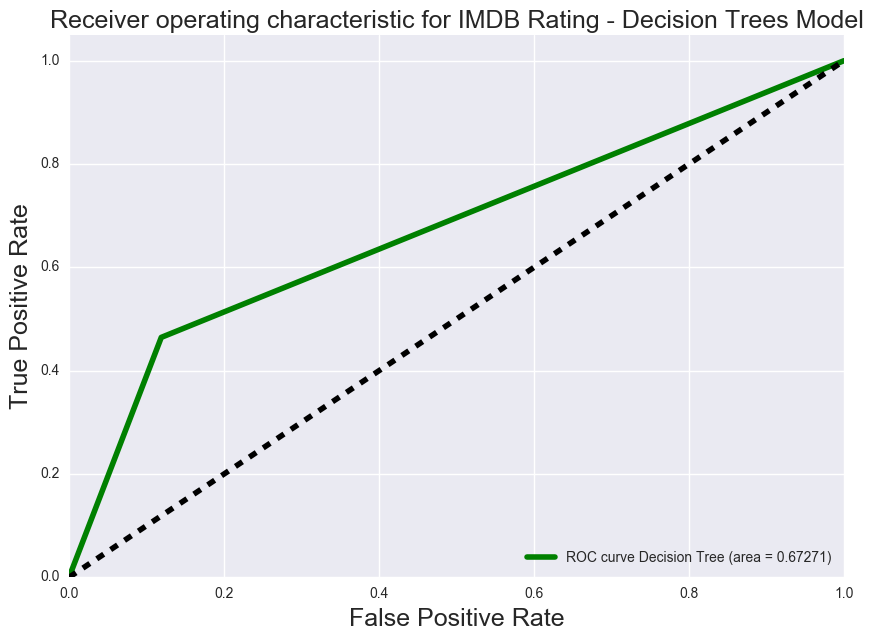

In [740]:
y_pp_dt = pd.DataFrame(dt.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])

FPR_T = dict()
TPR_T = dict()
ROC_AUC_T = dict()

# For class 1, find the area under the curve

FPR_T[1], TPR_T[1], _ = roc_curve(y_test,y_pp_dt['class_1_pp'])
ROC_AUC_T[1] = auc(FPR_T[1],TPR_T[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[10,7])

plt.plot(FPR_T[1], TPR_T[1],label='ROC curve Decision Tree (area = %0.5f)' % ROC_AUC_T[1], linewidth=4, color = 'green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for IMDB Rating - Decision Trees Model', fontsize=18)
plt.legend(loc="lower right")
plt.show()

If the base case is would be predicting all were high rating, then that would be 20% correct. This is model gives me about 50% correct, if I say it will be a highly rated movie, i have 50/50 shot. We can do better....

### Random Forest Model

In [741]:
rf = rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
rf.feature_importances_
rf_importance = pd.DataFrame(rf.feature_importances_,index=X.columns,columns=['rf_importance'])
rf_importance.sort_values('rf_importance',ascending = False)

,rf_importance
runtime,0.233000
Budget,0.153196
year,0.122478
bottom_actors,0.091131
mid_actors,0.075551
mid_director,0.058099
top_actors,0.049952
top_director,0.046787
drama,0.036828
big_six,0.035506


In [811]:
print "Accuracy Score is:",accuracy_score(y_test,rf_pred)
print "F1 Score is:",f1_score(y_test,rf_pred)
print "Precision Score is:",precision_score(y_test,rf_pred)
print "Recall Score is:",recall_score(y_test,rf_pred)
print classification_report(y_test,rf_pred)
pd.DataFrame(confusion_matrix(y_test,rf_pred),index=['not_rating_high','rating_high'],columns = ['pred_not_rating_high','pred_rating_high'])

Accuracy Score is: 0.83813559322
F1 Score is: 0.464985994398
Precision Score is: 0.703389830508
Recall Score is: 0.347280334728
             precision    recall  f1-score   support

          0       0.85      0.96      0.90       941
          1       0.70      0.35      0.46       239

avg / total       0.82      0.84      0.82      1180



,pred_not_rating_high,pred_rating_high
not_rating_high,906,35
rating_high,156,83


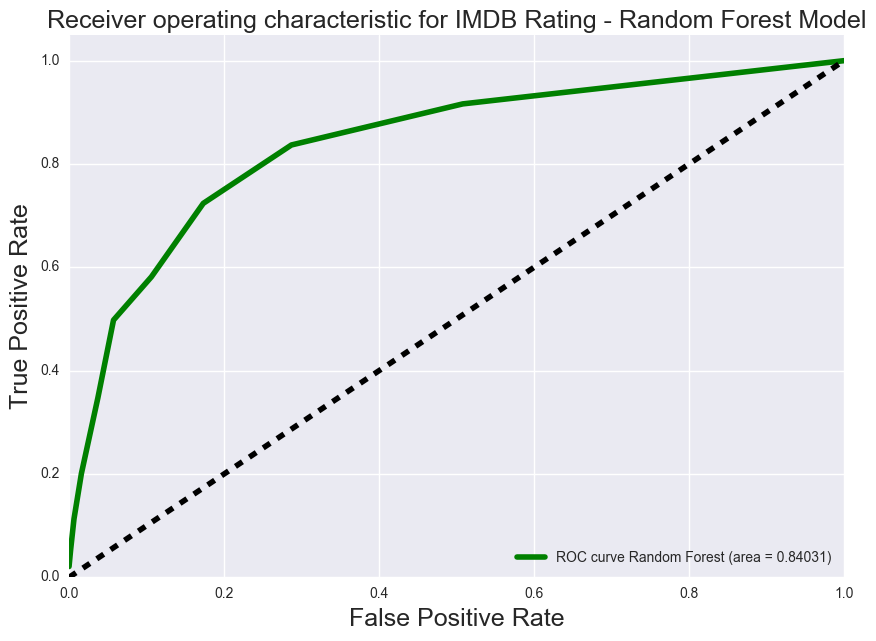

In [743]:
y_pp_rf = pd.DataFrame(rf.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])

FPR_T = dict()
TPR_T = dict()
ROC_AUC_T = dict()

# For class 1, find the area under the curve

FPR_T[1], TPR_T[1], _ = roc_curve(y_test,y_pp_rf['class_1_pp'])
ROC_AUC_T[1] = auc(FPR_T[1],TPR_T[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[10,7])

plt.plot(FPR_T[1], TPR_T[1],label='ROC curve Random Forest (area = %0.5f)' % ROC_AUC_T[1], linewidth=4, color = 'green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for IMDB Rating - Random Forest Model', fontsize=18)
plt.legend(loc="lower right")
plt.show()

If the base case is would be predicting all were high rating, then that would be 20% correct. This is model gives me about 70% correct, thus a 10% improvement over Decision Trees, and 50% improvement over base case. Let's check Extra Trees.

### Extra Trees

In [744]:
et = et.fit(X_train,y_train)
et_pred = et.predict(X_test)
et.feature_importances_
et_importance = pd.DataFrame(et.feature_importances_,index=X.columns,columns=['et_importance'])
et_importance.sort_values('et_importance',ascending = False)

,et_importance
runtime,0.178537
Budget,0.126385
year,0.119760
bottom_actors,0.111312
mid_actors,0.071306
mid_director,0.066211
big_six,0.061435
top_director,0.053042
drama,0.043861
super_director,0.034719


In [745]:
print "Accuracy Score is:",accuracy_score(y_test,et_pred)
print "F1 Score is:",f1_score(y_test,et_pred)
print "Precision Score is:",precision_score(y_test,et_pred)
print "Recall Score is:",recall_score(y_test,et_pred)
print classification_report(y_test,et_pred)
pd.DataFrame(confusion_matrix(y_test,et_pred),index=['not_rating_high','rating_high'],columns = ['pred_not_rating_high','pred_rating_high'])

Accuracy Score is: 0.826271186441
F1 Score is: 0.456233421751
Precision Score is: 0.623188405797
Recall Score is: 0.359832635983
             precision    recall  f1-score   support

          0       0.85      0.94      0.90       941
          1       0.62      0.36      0.46       239

avg / total       0.81      0.83      0.81      1180



,pred_not_rating_high,pred_rating_high
not_rating_high,889,52
rating_high,153,86


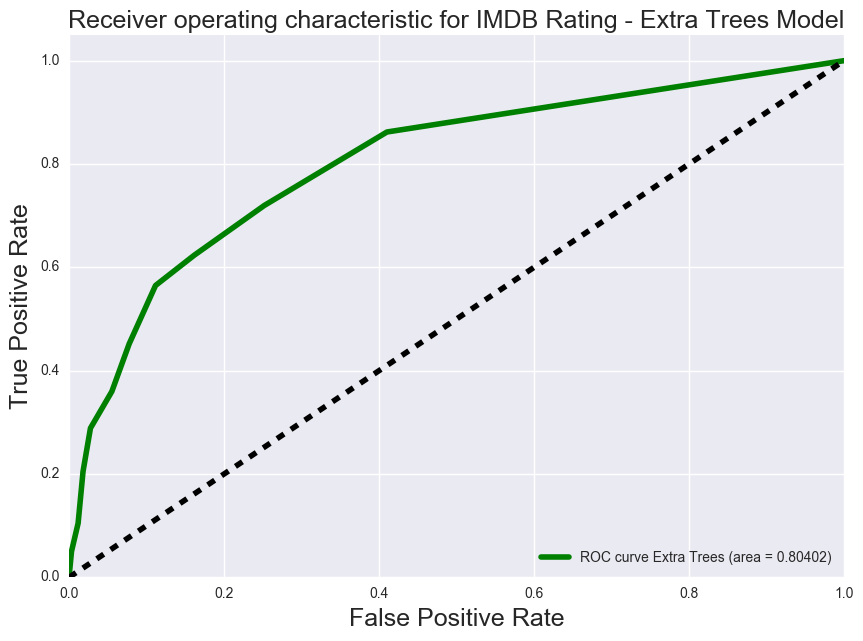

In [746]:
y_pp_et = pd.DataFrame(et.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])

FPR_T = dict()
TPR_T = dict()
ROC_AUC_T = dict()

# For class 1, find the area under the curve

FPR_T[1], TPR_T[1], _ = roc_curve(y_test,y_pp_et['class_1_pp'])
ROC_AUC_T[1] = auc(FPR_T[1],TPR_T[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[10,7])

plt.plot(FPR_T[1], TPR_T[1],label='ROC curve Extra Trees (area = %0.5f)' % ROC_AUC_T[1], linewidth=4, color = 'green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for IMDB Rating - Extra Trees Model', fontsize=18)
plt.legend(loc="lower right")
plt.show()

If the base case is would be predicting all were high rating, then that would be 20% correct. This is model gives me about 62% correct, thus a 8% improvement over Decision Trees, 8% decrease versus Random Forest and 32% improvement over base case

### Gradient Boosting

In [747]:
gb = gb.fit(X_train,y_train)
gb_pred = gb.predict(X_test)
gb.feature_importances_
gb_importance = pd.DataFrame(gb.feature_importances_,index=X.columns,columns=['gb_importance'])
gb_importance.sort_values('gb_importance',ascending = False)

,gb_importance
runtime,0.248422
Budget,0.191788
year,0.090534
bottom_actors,0.070966
mid_director,0.063056
drama,0.059183
top_director,0.051370
super_director,0.042273
top_actors,0.041062
big_six,0.037268


In [748]:
print "Accuracy Score is:",accuracy_score(y_test,gb_pred)
print "F1 Score is:",f1_score(y_test,gb_pred)
print "Precision Score is:",precision_score(y_test,gb_pred)
print "Recall Score is:",recall_score(y_test,gb_pred)
print classification_report(y_test,gb_pred)
pd.DataFrame(confusion_matrix(y_test,gb_pred),index=['not_rating_high','rating_high'],columns = ['pred_not_rating_high','pred_rating_high'])

Accuracy Score is: 0.863559322034
F1 Score is: 0.56836461126
Precision Score is: 0.791044776119
Recall Score is: 0.443514644351
             precision    recall  f1-score   support

          0       0.87      0.97      0.92       941
          1       0.79      0.44      0.57       239

avg / total       0.86      0.86      0.85      1180



,pred_not_rating_high,pred_rating_high
not_rating_high,913,28
rating_high,133,106


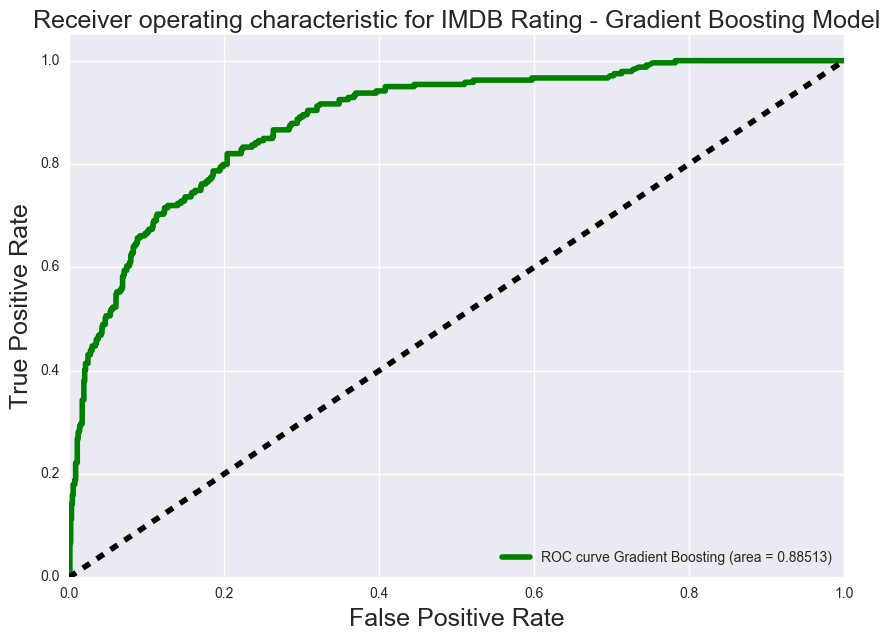

In [749]:
y_pp_gb = pd.DataFrame(gb.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])

FPR_T = dict()
TPR_T = dict()
ROC_AUC_T = dict()

# For class 1, find the area under the curve

FPR_T[1], TPR_T[1], _ = roc_curve(y_test,y_pp_gb['class_1_pp'])
ROC_AUC_T[1] = auc(FPR_T[1],TPR_T[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[10,7])

plt.plot(FPR_T[1], TPR_T[1],label='ROC curve Gradient Boosting (area = %0.5f)' % ROC_AUC_T[1], linewidth=4, color = 'green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for IMDB Rating - Gradient Boosting Model', fontsize=18)
plt.legend(loc="lower right")
plt.show()

If the base case is would be predicting all were high rating, then that would be 20% correct. This is model gives me about 79% correct, which is a 9% increase over Random Forest.

## Conclusion

Using Gradient Boosting, we get the following scores:
* AUC: 0.88
* Accuracy: 0.86 
* Precision: 0.79 (TP / (TP+FP) - Goal is to limit Type I Error if transaction cost to purchase movie is high
* Recall: 0.44 (TP / (TP + FN) - Goal is to limit Type II Error if transaction cost to purchase movie is low

Random Forest was pretty close in scores:
* AUC: 0.84
* Accuracy: 0.84 
* Precision: 0.70 (TP / (TP+FP) - Goal is to limit Type I Error
* Recall: 0.34 (TP / (TP + FN)

While of the High Rating movies, prediction guessed that most of them were not high. While that might be a problem, in this scenario, we want to find movies that are going to be highly rated, such that we want to buy low. 

If the Type I error is high, we are essentially buying lemons (bad movies) that will not do well. If the Type II error is high, then we are missing out on buying movies that will be highly rated. Therefore one must evaluate the cost of buying movies in this scenario, if it is low enough, then the cost of buying a lemon might not be an issue and we might miss the upside of not buying a hit movie. If the cost is high, then minimizing Type I error should be the strategy. In this scenario, I assume transaction cost to purchase movie is high, thus reasoning to limit Type I error.

Deciding to keep directors and actors is a toss up. As it isn't static with time, it is dynamic, top directors/actors a decade ago, might not be the top right now, and same will be true in the next decade. Thus to truly evaluate then one must restrict period of years to last 5-10 years.